Import the required libraries.

In [1]:
from pynucseg import ReferenceImage # or import pynucseg
import numpy as np  # !pip install numpy
import pandas as pd  # "!pip install pandas"
import matplotlib.pyplot as plt  # !pip install matplotlib
import plotly.express as px # !pip install plotly nbformat
import plotly.io as pio # kaleido is required. TO install >>> !pip install -U kaleido
import seaborn as sns

import os
import shelve

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Define file path and names.

In [2]:
root_path = 'E:/Lab/'  # 'D:/User Folders/Ganesh/' 
# file_path = 'H2B + PolII/230301 V6.5 P3/Intensity measurement in PBS/'
file_path = 'Data/H2B + PolII/SRX output/Intensity measurement in PBS/230306 V6.5 P6 Dish2/' # 230301 V6.5 P3/
output_path = "Python output".join(file_path.split('SRX output'))
n_fov = 4  # number of filed of views
n_channel = 2  # number of channels with fluorescent nucleus 
field_of_view='f' # the very first prefix of the file name
probe1_name = 'H2B'
probe2_name = 'PolII'
transmitted_name ='t'
# imaging_set can be in any format/type
imaging_setup = {'Laser': ['640nm', ['488nm']],
                 'Power': ["0.1'%' of 60%","0.1'%' of 60%" ],
                 'Exposure': ['100ms', '100ms'],
                 }


Check if the output folder exist, if not create.

In [3]:
print(output_path)
# check_folder = os.path.isdir(root_path+output_path)  # True if outputPath exists
# If folder doesn't exist, then create it.
if not os.path.isdir(root_path+output_path):
    os.makedirs(root_path+output_path)
    print("created folder : ", root_path+output_path)


Data/H2B + PolII/Python output/Intensity measurement in PBS/230306 V6.5 P6 Dish2/


Construct ReferenceImage objects and store images, perform smoothing and intensity computations inplace.

In [4]:
# images = []
for fov in range(n_fov):
    img = ReferenceImage(root_path=root_path,
                   file_path=file_path,
                   field_of_view=field_of_view+str(fov+1),
                   probe1_name=probe1_name,
                   probe2_name=probe2_name,
                   transmitted_name='t',
                   imaging_setup=imaging_setup,
                   )
    # median filtering to smooth out
    img.smoothing(image_name=probe2_name,sigma=8)

    # run segmentation
    img.run_segmentaion2d(prob_thresh=0.5,
                          nms_threhold=0.01,
                          scale=0.2,  # scale down the image prior segmentation,
                          )

    # get measuremtns, save result inplace, do not spit out
    # default area per pixel is 0.01 um^2 assuming 1 pixel=100nm
    img.get_cell_info(probe_names=[probe1_name,probe2_name]) 

ReferenceImage created with: ['t', 'H2B', 'PolII']
1/1 [==============================] - 0s 278ms/step
ReferenceImage created with: ['t', 'H2B', 'PolII']
1/1 [==============================] - 0s 66ms/step
ReferenceImage created with: ['t', 'H2B', 'PolII']
1/1 [==============================] - 0s 65ms/step
ReferenceImage created with: ['t', 'H2B', 'PolII']
1/1 [==============================] - 0s 69ms/step


Extract result to DataFrame, and save to disk as csv.

In [5]:
imgs_list = ReferenceImage.all_fovs
area_n_ADU = np.empty((0,n_channel+3))
for fov in range(n_fov):
    # get [area, mean_intensity_per_pixel) per field of view
    area_n_ADU_per_cell = imgs_list[fov].area_n_ADU
    # add FOV_ID and Cell_ID column 
    area_n_ADU_per_cell_w_fovID = np.hstack(
        (area_n_ADU_per_cell,
         np.repeat(int(fov+1),area_n_ADU_per_cell.shape[0]).reshape(-1,1),
         np.arange(1,area_n_ADU_per_cell.shape[0]+1).reshape(-1,1),
         ))
    # concatenate  the values in the main array
    area_n_ADU = np.vstack((area_n_ADU,area_n_ADU_per_cell_w_fovID))

# delete temporaty files from workspace
del area_n_ADU_per_cell, area_n_ADU_per_cell_w_fovID

# construct pandas DataFrame 
intensity_df = pd.DataFrame(data=area_n_ADU,columns=['Area_um2',probe1_name,probe2_name,'FOV_ID','Cell_ID'])
intensity_df['FOV_ID'] = intensity_df['FOV_ID'].astype(int)  # int or str. str make FOV_ID categorical
intensity_df['Cell_ID'] = intensity_df['Cell_ID'].astype(int)  # int or str. str make FOV_ID categorical
intensity_df['FOV_ID'] = intensity_df['FOV_ID'].astype(str)  # int or str. str make FOV_ID categorical
intensity_df['Cell_ID'] = intensity_df['Cell_ID'].astype(str)  # int or str. str make FOV_ID categorical


# filter out the nucleus that has very small or big area, potential false positive
min_area = 75 # um^2  ~ circle of diameter 9.7 um
max_area = 175 # um^2  ~ circle of diameter 14.9 um

# filter out the DataFrame, i.e. consider only the nucles with area: min_area <= area <= max_area 
filtered_intensity_df = intensity_df.loc[(intensity_df['Area_um2'] >= min_area) & (intensity_df['Area_um2'] <= max_area)]
# save DataFrame to disk as csv
filtered_intensity_df.to_csv(root_path+output_path+'mean_intensity_per_pxl.csv',index=None)


Violins for mean intensities per nucleus per probe. 

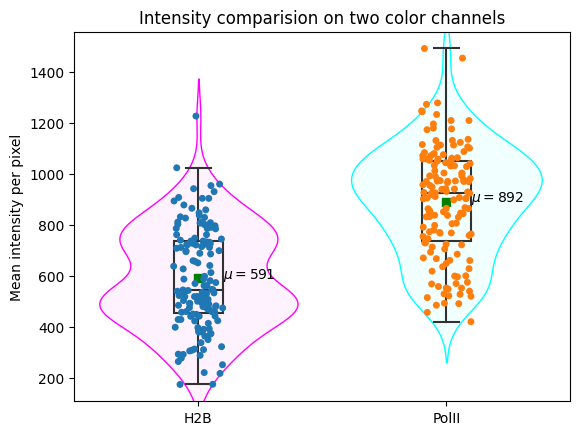

In [6]:
title = 'Intensity comparision on two color channels'
fig, ax = plt.subplots()
ax = sns.violinplot(data=filtered_intensity_df[[probe1_name,probe2_name]], inner=None, linewidth=1, saturation=0.5,alpha=0)

# change alpha for edges and faces
ax.collections[0].set_edgecolor((1,0,1, 1))
ax.collections[1].set_edgecolor((0,1, 1,1))
ax.collections[0].set_facecolor((1,0,1, 0.05))
ax.collections[1].set_facecolor((0,1,1, 0.05))

sns.boxplot(data=filtered_intensity_df[[probe1_name,probe2_name]], saturation=0.5, width=0.2,
            palette='rocket', boxprops={'zorder': 2,'facecolor': 'None'},  ax=ax,
            showfliers=False)

sns.stripplot(data=filtered_intensity_df[[probe1_name,probe2_name]], jitter=True)

means = filtered_intensity_df[[probe1_name,probe2_name]].mean()
ax.plot([0,1],means,'sg')
# Add text to the plot
plt.text(0+0.1, means[probe1_name], f"$\mu=${round(means[probe1_name])}")
plt.text(1+0.1, means[probe2_name], f"$\mu=${round(means[probe2_name])}")

# adjust axis limits
# ax.set_ylim(-100,1000)
ax.set_xlim(-0.5,1.5)
ax.set_ylabel('Mean intensity per pixel')
ax.set_title(title)
# show plot
plt.savefig(root_path+output_path+ title+'.png')
plt.show();

Area versus intensity per probe.

In [7]:
fig = px.scatter(data_frame=filtered_intensity_df,
                 x='Area_um2',
                 y=[probe1_name],
                 color='FOV_ID',
                 hover_data=['FOV_ID','Cell_ID'])
fig.update_layout(
    yaxis_title='Mean intensity per pixel',
    xaxis_title='Area of cell in um^2',
    title=dict(
        text=probe1_name+' intensity versus nucleus size',
        x=0.5,
        y=0.95,
        xanchor="center",
        yanchor="top",
        ),
)
pio.write_image(fig, root_path+output_path+'area_vs_intensity '+probe1_name+'.png',format='png')
fig.show()

In [8]:
fig = px.scatter(data_frame=filtered_intensity_df,
                 x='Area_um2',
                 y=[probe2_name],
                 color='FOV_ID',
                 hover_data=['FOV_ID','Cell_ID'])
fig.update_layout(
    yaxis_title='Mean intensity per pixel',
    xaxis_title='Area of cell in um^2',
    title=dict(
        text=probe2_name+' intensity versus nucleus size',
        x=0.5,
        y=0.95,
        xanchor="center",
        yanchor="top",
        ),
)
pio.write_image(fig, root_path+output_path+'area_vs_intensity '+probe2_name+'.png',format='png')
fig.show()

View images and masks in napari.

In [9]:
# fov_to_visualize = 2
# to print list of names of available images
# imgs_list[fov_to_visualize].show_image_names()


# display images in napari
# imgs_list[fov_to_visualize-1].view_on_napari()

Save the `'imgs_list'` as pickle file.

In [10]:
results = shelve.open(root_path+output_path+'results', writeback=True)
results['imgs_list'] = imgs_list
results.sync()
results.close()